# Approximating Steel Cased Wells - DC

[Lindsey Heagy](http://github.com/lheagy)

In this example, we examine the impact of upscaling the well using
- the assumption that the well is a solid rod of steel
- averaging conductivity such that the $\sigma A$ is the same in both cases

These experiments are conducted at DC. 

SimPEG and the implementation for electrical and electromagnetic methods is described in ([Cockett et al., 2015](https://doi.org/10.1016/j.cageo.2015.09.015) and [Heagy et al., 2017](https://arxiv.org/abs/1610.00804)).

In [1]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot
import ipywidgets

from SimPEG.EM import TDEM
from SimPEG import Utils, Maps

import casingSimulations as casingSim

from pymatsolver import Pardiso

%matplotlib inline

##  Parameters

To examine the impact of replacing the steel cased well with a solid well, I have run a few simulations using SimPEG and simulating the DC resistivity equations using a finite volume approach on a 3D cylindrical mesh.  

The model setup follows . The electrical conductivities used are:
- Casing $1\times 10^6$ S/m
- Air $3\times10^{-7}$ S/m
- Background $3\times10^{-2}$ S/m
- Inside the casing - same as background

In the first example, the well is 200m long. The thickness of the casing is 12mm. Here, we are interested in examining a top casing source, where one electrode is connected to the top of the casing and a return electrode is some radial distance away on the surface. In the following examples, we will put the return electrode a distance of 2x the length of the well (for the first example, it is 400 m away). For datam we measure the radial electric field along a line $90^\circ$ from the source wire, starting from the well and measuring out to a distance of 400m away. 

### Experiments

From the base example, there are 3 that are setup, you can select one by changing the `experiment` variable or setting your own values for `casing_l`, `sigma_back` and `sigma_air`.

In [2]:
simDir = 'DC_approximations'  # create a simulation directory where results can be saved. 

### select an experiment

In [3]:
casing_l = 1000
sigma_back = 0.01

In [4]:
casing_t = 10e-3 # 10mm thick casing
casing_d = 100e-3 # 10cm diameter

model = casingSim.model.CasingInHalfspace(
    directory = simDir,
    sigma_casing = 5e6,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
    sigma_air = 3e-7,   # conductivity of the air
    casing_d = casing_d-casing_t,  # 135mm is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_t, 
    src_a = np.r_[0., np.pi, -1.25],  # put the A electrode just below the surface
    src_b = np.r_[casing_l, np.pi, -1.25] # put the return electrode at a distance of 2 x length of well away
)

# adjust the src_a location so it is connected to well
model.src_a = np.r_[model.casing_r, np.pi, -1.25]  

In [5]:
# Here we print the parameters being used to set up the simulation
mdict = model.serialize()
mdict.pop('__class__')

'CasingInHalfspace'

In [6]:
model2 = casingSim.model.CasingInHalfspace(**mdict)
model2.serialize()

{'__class__': 'CasingInHalfspace',
 'casing_d': 0.09000000000000001,
 'casing_l': 1000.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'directory': 'DC_approximations',
 'filename': 'ModelParameters.json',
 'mur_back': 1.0,
 'mur_casing': 1.0,
 'sigma_air': 3e-07,
 'sigma_back': 0.01,
 'sigma_casing': 5000000.0,
 'sigma_inside': 0.01,
 'src_a': [0.045000000000000005, 3.141592653589793, -1.25],
 'src_b': [1000.0, 3.141592653589793, -1.25],
 'surface_z': 0.0,
 'version': '0.0.5'}

## Mesh

Here we set up a 3D cylindrical mesh, discretizing in $x$, $\theta$ and $z$. 

To discretize in x, we start by defining the finest region of the mesh, ensuring that we have 4 cells across the thickness of the casing. From there, we expand the cell sizes until we reach the second uniform cell size we want to model at (`csx2`). We then use a constant cell spacing of `csx2` until we have meshed out to the end of the domain in which we want to examine data (`domainx2`). Beyond that, we add padding cells to *"infinity"*

In [7]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 50.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 500  # go out 500m from the well

# padding parameters
npadx, npadz = 6, 12  # number of padding cells
pfx = 1.5
pfx2 = 2  # expansion factor for the padding to infinity in the x-direction
pfz = 1.8

# discretization in theta
ncy = 16
hy = np.ones(ncy)
hy = hy * 2*np.pi/hy.sum()

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=simDir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
    hy=hy,   # cell spacings in the 
    csx1=model.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx1=pfx, 
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


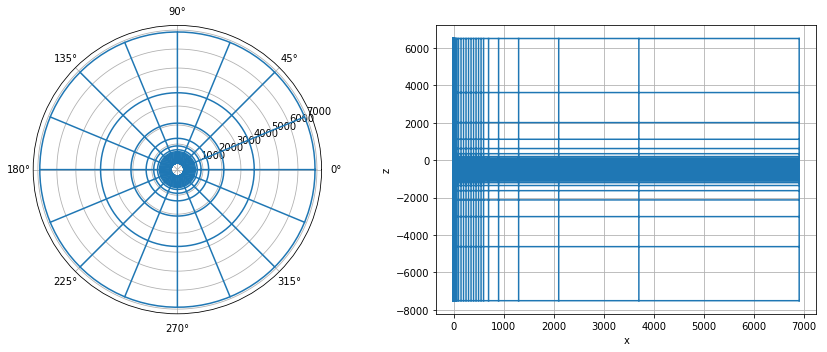

In [8]:
cylMeshGen.mesh.plotGrid()

In [9]:
# mesh 1

def get_cart_mesh(csx_cart):
    csz_cart = 2.5 if csx_cart < 2.5 else csx_cart
    npadz = 1

    ncz = int(casing_l/csz_cart)
    
#     csx2 = 50. 
    npadx1 = 1.
    npadx2 = 1.
    npady = 1. 
    pfx1 = 1.5
    pfy = 1.7
    pfx2 = 2
    pfz = 1.8
    
    # finest uniform region
    hx1a = Utils.meshTensor([(csx_cart, 3)])
    hx1b = Utils.meshTensor([(csx_cart, npadx1, pfx1)])

    # pad to second uniform region
    while hx1b.sum() < csx2:
        npadx1 += 1
        hx1b = Utils.meshTensor([(csx_cart, npadx1, pfx1)])

    # scale padding so it matches cell size properly
    dx1 = sum(hx1a)/2.+sum(hx1b)
    dx1 = np.floor(dx1/csx2)
    hx1b *= (dx1*csx2 - sum(hx1a))/sum(hx1b)

    # second uniform chunk of mesh
    ncx2 = np.ceil((domainx2 - dx1)/csx2) + 1
    hx2a = Utils.meshTensor([(csx2, ncx2)])

    hx2b = Utils.meshTensor([(csx2, npadx2, pfx2)])
    while hx2b.sum() < 5000:
        # pad to infinity
        npadx2 += 1
        hx2b = Utils.meshTensor([(csx2, npadx2, pfx2)])

    hx = np.hstack([hx1b, hx2a, hx2b])
    
    hx = np.hstack([np.flipud(hx), hx1a, hx])
    hy = Utils.meshTensor([(csx_cart, npady, pfy)])
    while hy.sum() < 5000:
        # pad to infinity
        npady +=1
        hy = Utils.meshTensor([(csx_cart, npady, pfy)])
    hy = np.hstack([np.flipud(hy), hx1a, hy])
    
    hz = discretize.utils.meshTensor([(csz_cart, npadz, -pfz), (csz_cart, ncz), (csz_cart, npadz, pfz)])
    
    while hz.sum() < 8000:
        npadz = npadz+1
        hz = discretize.utils.meshTensor([(csz_cart, npadz, -pfz), (csz_cart, ncz), (csz_cart, npadz, pfz)])    

    cart_mesh = discretize.TensorMesh(
        [hx, hy, hz], x0='CCC'
    )
    cart_mesh.x0[2] = -np.sum(hz[:npadz+ncz])
    
    print("{}: {}".format(csx_cart, cart_mesh.nC))
    return cart_mesh

In [10]:
csx_cart = casing_d* np.r_[1., 2., 4., 8.]
cart_mesh_dict = {
    key: get_cart_mesh(key) for key in csx_cart
}

0.1: 1090026
0.2: 971022
0.4: 889998
0.8: 738078


In [11]:
cylMeshGen.mesh.hx[cylMeshGen.mesh.hx < 50].sum()

100.0

In [12]:
cart_mesh_dict[0.1].hx[cart_mesh_dict[0.1].hx < 50].sum()/2

49.849999999999994

In [13]:
def cart_casing_inds(key):
    cart_mesh = cart_mesh_dict[key]
    inds = (
        (cart_mesh.gridCC[:, 0] > -casing_d/2.) & (cart_mesh.gridCC[:, 0] < casing_d/2.) &
        (cart_mesh.gridCC[:, 1] > -casing_d/2.) & (cart_mesh.gridCC[:, 1] < casing_d/2.) &
        (cart_mesh.gridCC[:, 2] > -casing_l) & (cart_mesh.gridCC[:, 2] < 0)
    )
    return inds

In [14]:
def get_sigma_cart(key, aniso):
    cart_mesh = cart_mesh_dict[key]
    
    sigma_cart = np.ones(cart_mesh.nC) * model.sigma_air
    sigma_cart[cart_mesh_dict[key].gridCC[:, 2] < 0 ] = model.sigma_back
    
    casing_inds = cart_casing_inds(key)
    
    casing_A = np.pi*(model.casing_b**2 - model.casing_a**2)
    sigma_casing_cart = (model.sigma_casing * casing_A + model.sigma_back *(key**2 - casing_A))  / key**2
    
    print("sig_z  = {:1.2e}".format(sigma_casing_cart))
    sigma_cart[casing_inds] = sigma_casing_cart
    
    if aniso is True: 
        sigma_xy = sigma_cart.copy()

        # treat horizontal like a series circuit

#         sig_xy = (key/2.)/(model.casing_t / model.sigma_casing + (key/2. - model.casing_t)/model.sigma_back)
        
        sig_xy = key**2 / (casing_A/model.sigma_casing + (key**2 - casing_A)/ model.sigma_back)
        print("sig_xy = {:1.2e}".format(sig_xy))

        sigma_xy[casing_inds] = sig_xy
        sigma_cart = np.vstack([sigma_xy, sigma_xy, sigma_cart]).T
    
    return sigma_cart

In [15]:
cart_model_dict = {
    key : {
        key2 : get_sigma_cart(key, True if key2 == "aniso" else False) for key2 in ["iso"]
    } for key in csx_cart
}

sig_z  = 1.41e+06
sig_z  = 3.53e+05
sig_z  = 8.84e+04
sig_z  = 2.21e+04


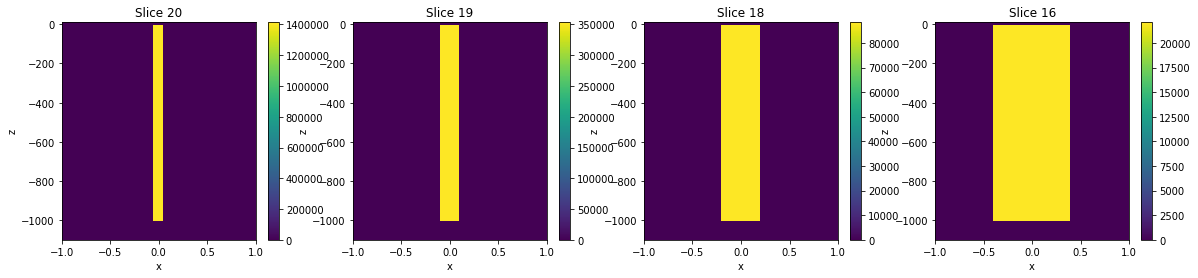

In [16]:
fig, ax = plt.subplots(1, len(csx_cart), figsize=(5*len(csx_cart), 4))

if len(csx_cart) == 1:
    ax = [ax]

for i, key in enumerate(csx_cart): 
    plt.colorbar(cart_mesh_dict[key].plotSlice(cart_model_dict[key]["iso"], normal="Y", ax=ax[i])[0], ax=ax[i])
    ax[i].set_xlim(np.r_[-1., 1])
    ax[i].set_ylim(np.r_[-1100, 10])

In [17]:
cart_mesh_dict

{0.1: <discretize.TensorMesh.TensorMesh at 0x11b6fdef0>,
 0.2: <discretize.TensorMesh.TensorMesh at 0x11b85be80>,
 0.4: <discretize.TensorMesh.TensorMesh at 0x11b850fd0>,
 0.8: <discretize.TensorMesh.TensorMesh at 0x11b83c940>}

## set up the survey and sources

In [18]:
src_theta = np.pi + hy[0]/2

model.src_a[1] = src_theta
model.src_b[1] = src_theta

# for m in modelDict.values():
#     m.src_a[1] = src_theta
#     m.src_b[1] = src_theta

In [19]:
cyl_mesh = cylMeshGen.mesh
src_b = model.src_b

In [20]:
src_b = cyl_mesh.gridCC[discretize.utils.closestPoints(cyl_mesh, src_b, 'CC'), :]
print(src_b)
model.src_b = discretize.utils.mkvc(src_b)

[[1100.            3.33794219   -1.25      ]]


(0.0, 3000)

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


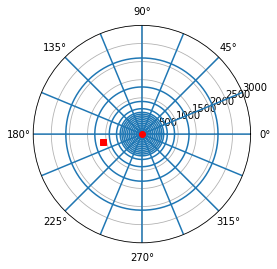

In [21]:
# Plot the source location

ax = plt.subplot(111, projection='polar')
cylMeshGen.mesh.plotGrid(ax=ax, slice='z')
ax.plot(model.src_a[1], model.src_a[0], 'ro')
ax.plot(model.src_b[1], model.src_b[0], 'rs')
ax.set_ylim([0., 3000])

## Create models to compare to

Here, we create two more models which we want to simulate on
- `solid` fills in the center of the casing with a conductivity equal to that of steel
- `sigma_A` approximates the casing as a solid rod with conductivity found by preserving the conductivity - cross sectional area product. 

In [22]:
# Assign physical properties on the mesh
modelDict = {
    'baseline': model
}
physpropsDict = {
    'baseline': casingSim.model.PhysicalProperties(cylMeshGen, model),
}
model_names = ['baseline']

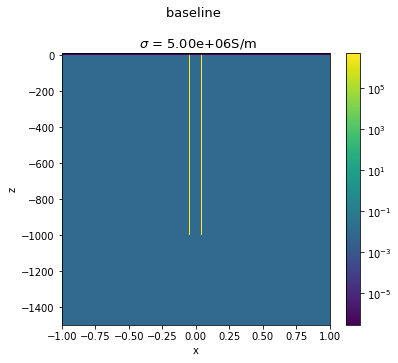

In [23]:
# Plot the models
xlim = np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.5*model.casing_l, 10.]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5))
if len(model_names) == 1:
    ax = [ax]

for a, title in zip(ax, model_names):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(title, pp.modelParameters.sigma_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

In [24]:
model.src_a

array([ 0.045     ,  3.33794219, -1.25      ])

In [25]:
# Set up 4 sources, top casing, top & not coupled, downhole, downhole not coupled

src_a = np.vstack([
    [model.casing_r, np.pi, -1.25],
])

src_b = np.ones((src_a.shape[0],1)) * model.src_b

src_names = [
    "top casing",
]

(-1100.0, 1)

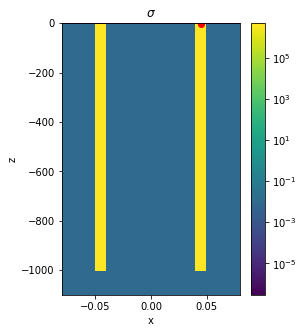

In [26]:
# Plot the source location

symbols = ['ro', 'ws', 'k>', 'mo', 'c*', 'C3s']

fig, ax = plt.subplots(1, 1, figsize=(4, 5))
# cylMeshGen.mesh.plotGrid(ax=ax, slice='theta')
physpropsDict['baseline'].plot_sigma(
    ax=ax, 
    pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
)

for i in range(src_a.shape[0]):
    ax.plot(src_a[i, 0], src_a[i, 2], symbols[i])
    ax.plot(src_b[i, 0], src_b[i, 2], symbols[i])
    
ax.set_xlim([-0.08, 0.08]) #src_b[:, 0].max()])
ax.set_ylim([ -1.1*model.casing_l, 1])


## set up a DC simulation

### Cyl simulation 

In [27]:
model_names

['baseline']

In [28]:
simDict = {}
for title in model_names:
    simDict[title] = casingSim.run.SimulationDC(
        modelParameters=modelDict[title], directory=simDir, 
        meshGenerator=cylMeshGen, 
        src_a=src_a, src_b=src_b
    )


Homogeneous Dirichlet is the natural BC for this CC discretization.


In [29]:
%%time
fieldsDict = {}
for title in model_names:
    print('--- Running {} ---'.format(title))
    fieldsDict[title] = simDict[title].run()
    print('\n')

--- Running baseline ---
Validating parameters...
      max x: 6900.0, min z: -7514.051520522243, max z: 6514.051520522245, nC: 430528
Saved DC_approximations/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 22.1324520111084


CPU times: user 32.5 s, sys: 1.87 s, total: 34.4 s
Wall time: 22.1 s


### Set up the Tensor simulation

In [30]:
from SimPEG import DC, Maps

In [31]:
src_a_cart = np.vstack([np.r_[0., 0., src_a[i, 2]] for i in range(src_a.shape[0])])
src_b_cart = np.vstack([np.r_[-src_b[i, 0], 0., src_b[i, 2]] for i in range(src_a.shape[0])])
              
print(src_a_cart, src_b_cart)

[[ 0.    0.   -1.25]] [[-1100.       0.      -1.25]]


In [32]:
key = 0.1
cart_mesh_dict[key].gridCC[discretize.utils.closestPoints(cart_mesh_dict[key], src_b_cart), :]

array([[-1.09985000e+03,  9.09494702e-13, -1.25000000e+00]])

/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


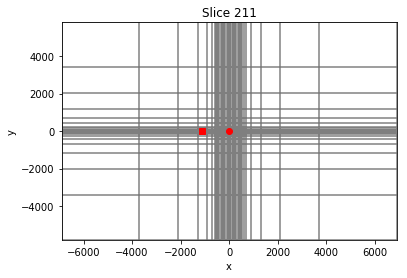

In [33]:
fig, ax = plt.subplots(1, 1)
key = 0.1
cart_mesh_dict[key].plotSlice(np.nan*np.ones(cart_mesh_dict[key].nC), normal='Z', grid=True, ax=ax)
# ax.set_xlim([-2500, 2500])
# ax.set_ylim([-2500, 2500])

ax.plot(src_a_cart[0][0], src_a_cart[0][1], 'ro')
ax.plot(src_b_cart[0][0], src_b_cart[0][1], 'rs')

In [34]:
import time

In [35]:
%%time
fields_dict_cart = {}

for key in csx_cart: 
    cart_mesh = cart_mesh_dict[key]
    tmp_dict = {}
    
    for iso_key, value in cart_model_dict[key].items():
        prob = DC.Problem3D_CC(
            cart_mesh,
            sigmaMap=Maps.IdentityMap(nP=cart_mesh.nC*3) if iso_key.startswith("aniso") else Maps.IdentityMap(nP=cart_mesh.nC),
            bc_type='Dirichlet',
            Solver=Pardiso
        )
        srcList = [
            DC.Src.Dipole([], src_a_cart[i, :], src_b_cart[i, :])
            for i in range(src_a_cart.shape[0])
        ]
                # self._src = DC.Src.Dipole([], self.src_a, self.src_b)
        survey = DC.Survey(srcList)

        prob.pair(survey)


        t = time.time()
        print('--- Running {} {} ---'.format(key, iso_key))
        tmp_dict[iso_key] = prob.fields(discretize.utils.mkvc(value))
        print('Elapsed time: {} \n'.format(time.time()-t))
    
    fields_dict_cart[key] = tmp_dict

Homogeneous Dirichlet is the natural BC for this CC discretization.
--- Running 0.1 iso ---
Elapsed time: 192.68633699417114 

Homogeneous Dirichlet is the natural BC for this CC discretization.
--- Running 0.2 iso ---
Elapsed time: 187.80566596984863 

Homogeneous Dirichlet is the natural BC for this CC discretization.
--- Running 0.4 iso ---
Elapsed time: 157.99017810821533 

Homogeneous Dirichlet is the natural BC for this CC discretization.
--- Running 0.8 iso ---
Elapsed time: 70.22930192947388 

CPU times: user 14min 44s, sys: 55.2 s, total: 15min 39s
Wall time: 10min 15s


## Plot Results

Here we plot the radial electric field along a line $90^{\circ}$ from the source. 

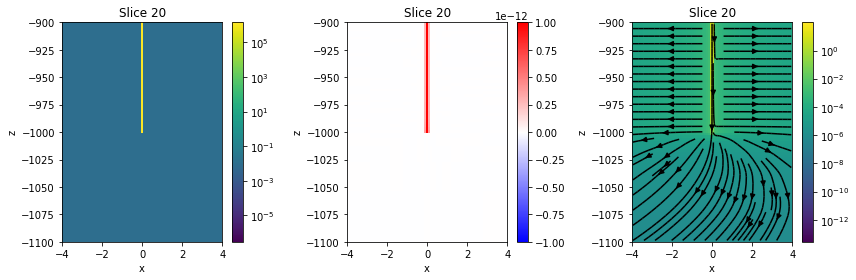

In [36]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))
src = survey.srcList[0]

key = 0.1
cart_mesh = cart_mesh_dict[key]

xlim = 4.*np.r_[-1, 1]
ylim = np.r_[-1100, -900]

plt.colorbar(
    cart_mesh.plotSlice(
        cart_model_dict[key]["iso"], ax=ax[0],
        pcolorOpts={"norm":LogNorm()},
        normal="Y"
    )[0], ax=ax[0]
)

plt.colorbar(
    cart_mesh.plotSlice(
        fields_dict_cart[key]["iso"][:, 'charge'], pcolorOpts = {"cmap":"bwr"}, ax=ax[1],
        clim = 1e-12*np.r_[-1, 1],
        normal="Y", #grid=True
    )[0], ax=ax[1]
)

plt.colorbar(
    cart_mesh.plotSlice(
        fields_dict_cart[key]["iso"][:, 'j'], "F", pcolorOpts = {"norm":LogNorm()}, ax=ax[2],
        view="vec",
        range_x = xlim, range_y = ylim,
        normal="Y", #grid=True
    )[0], ax=ax[2]
)

plt.tight_layout()

for a in ax: 
    a.set_xlim(xlim)
    a.set_ylim(ylim)

In [37]:
viewer = casingSim.FieldsViewer(sim_dict=simDict, fields_dict=fieldsDict)

(<matplotlib.collections.QuadMesh at 0x137949ba8>,
 <matplotlib.colorbar.Colorbar at 0x1d6e65d68>)

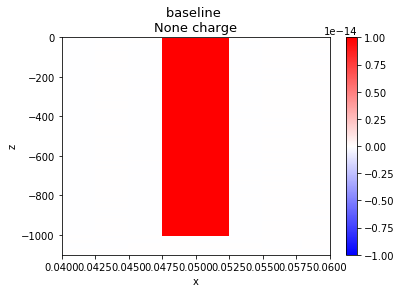

In [38]:
viewer.plot_cross_section(
    view="charge", xlim=[0.04, 0.06], zlim=[-1100, 0], clim=1e-14*np.r_[-1., 1.], 
)

In [39]:
viewer.widget_cross_section()

interactive(children=(FloatText(value=0.1, description='max_r'), FloatText(value=-10.0, description='min_depth'), FloatText(value=1250.0, description='max_depth'), FloatText(value=0.0, description='clim_min'), FloatText(value=0.0, description='clim_max'), ToggleButtons(description='model_key', options=('baseline', 'all'), value='baseline'), ToggleButtons(description='view', options=('sigma', 'e', 'j', 'phi', 'charge', 'charge_density'), value='sigma'), IntSlider(value=0, description='theta_ind', max=15), Checkbox(value=False, description='show_mesh'), Checkbox(value=False, description='use_aspect'), Checkbox(value=True, description='casing_outline'), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

In [40]:
def get_cartesian_current(key, iso_key): 
    cart_mesh = cart_mesh_dict[key]
    shift = 1
    zinds = (cart_mesh.vectorNz < model.casing_z[1]) & (cart_mesh.vectorNz > model.casing_z[0])
    z_currents = cart_mesh.vectorNz[zinds][:-1*shift]
    src = survey.srcList[0]

    casing_faces_z = (
        (cart_mesh.gridFz[:, 0] >= -model.casing_b) &
        (cart_mesh.gridFz[:, 0] <= model.casing_b) &
        (cart_mesh.gridFz[:, 1] >= -model.casing_b) &
        (cart_mesh.gridFz[:, 1] <= model.casing_b) &
        (cart_mesh.gridFz[:, 2] < model.casing_z[1]) &
        (cart_mesh.gridFz[:, 2] > model.casing_z[0])
    )

    iz = (
        discretize.utils.sdiag(casing_faces_z)*
        ((discretize.utils.sdiag(cart_mesh.area) * fields_dict_cart[key][iso_key][:, 'j'])[cart_mesh.vnF[:2].sum():])
    ).reshape(cart_mesh.vnFz, order='F')

    iz = ((iz.sum(0).sum(0))[zinds])[:-1*shift]
    
    return z_currents, iz

In [41]:
def get_cartesian_charge(key, iso_key):
    cart_mesh = cart_mesh_dict[key]

    charge = fields_dict_cart[key][iso_key][:, 'charge']
    
    casing_inds_wide = (
        (cart_mesh.gridCC[:, 0] >= -key*2) &
        (cart_mesh.gridCC[:, 0] <= key*2) &
        (cart_mesh.gridCC[:, 1] >= -key*2) &
        (cart_mesh.gridCC[:, 1] <= key*2) &
        (cart_mesh.gridCC[:, 2] < model.casing_z[1]) &
        (cart_mesh.gridCC[:, 2] > model.casing_z[0])
    )

    charge[~casing_inds_wide] = 0.
    charge = charge.reshape(cart_mesh.vnC, order='F').sum(0).sum(0)

    z_inds = (
        (cart_mesh.vectorCCz > model.casing_z[0]) &
        (cart_mesh.vectorCCz < model.casing_z[1])
    )
    charges = charge[z_inds]
    z_charges = cart_mesh.vectorCCz[z_inds]
    
    return z_charges, charges

In [42]:
# z_currents, iz_iso = get_cartesian_current("iso")
# z_currents, iz_aniso = get_cartesian_current("aniso")

# cart_currents_dict = {
#     "iso": iz_iso, "aniso": iz_aniso
# }

# z_charges, charges_iso = get_cartesian_charge("iso")
# z_charges, charges_aniso = get_cartesian_charge("aniso")

# cart_charges_dict = {
#     "iso": charges_iso, "aniso": charges_aniso
# }

In [43]:
import matplotlib.lines as mlines
from string import ascii_lowercase
from matplotlib import rcParams

rcParams['font.size'] = 12

[-995.  -992.5 -990. ]
[-995.  -992.5 -990. ]
[-995.  -992.5 -990. ]
[-995.  -992.5 -990. ]
[-995.  -992.5 -990. ]


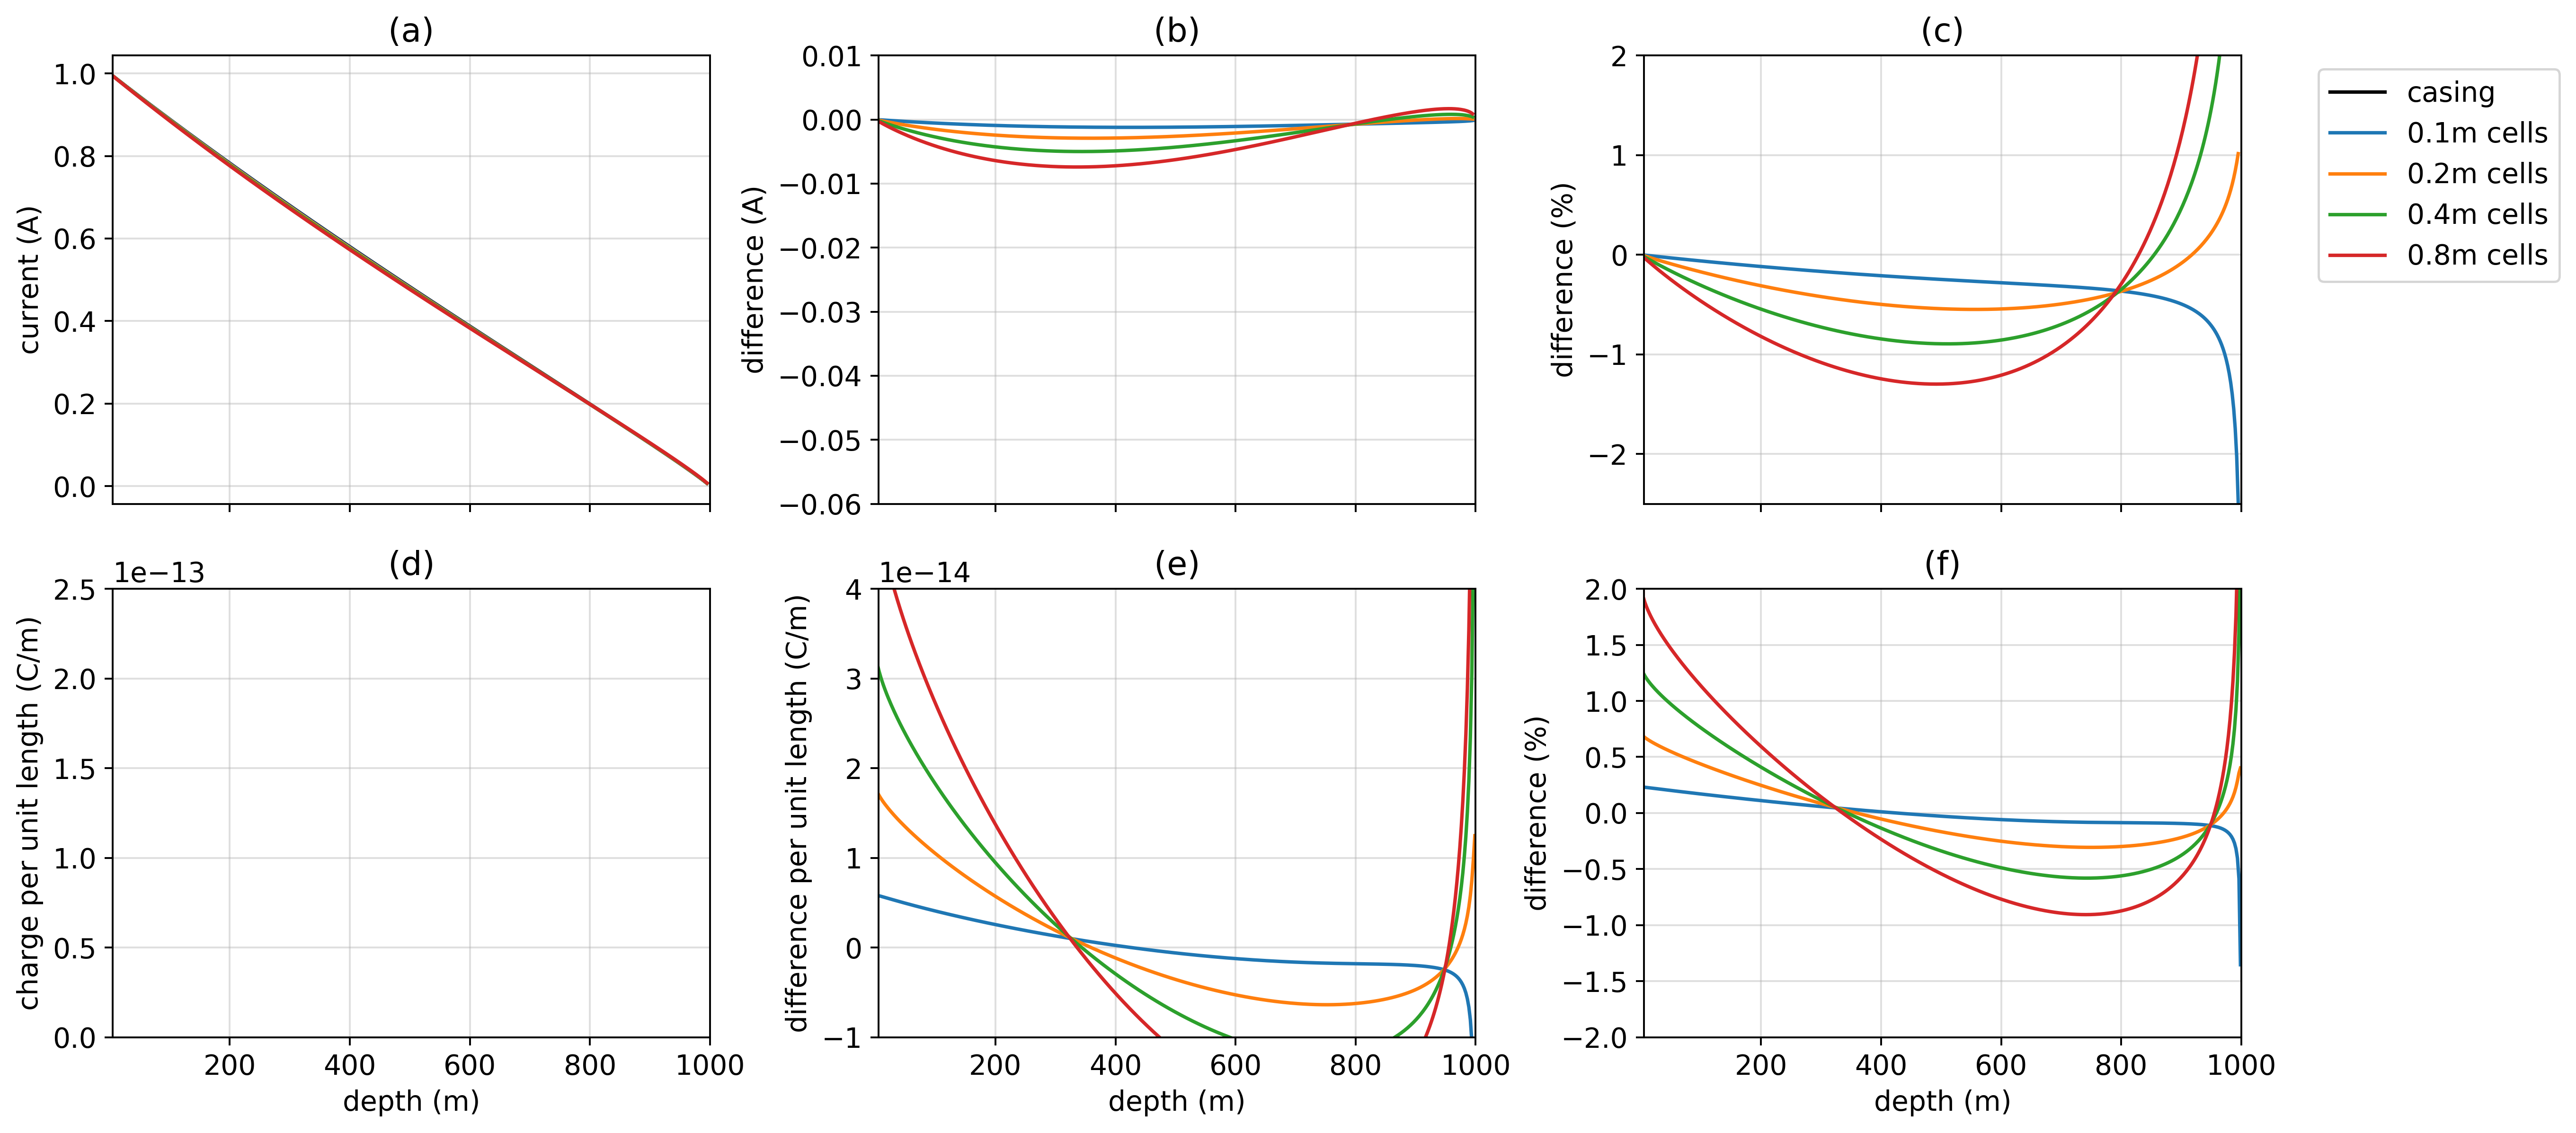

In [58]:
fig, ax  =  plt.subplots(2, 3, figsize=(14, 7), dpi=350)

src_ind = 0
mesh = cylMeshGen.mesh
src = simDict["baseline"].survey.srcList[src_ind]
z_currents, iz_casing = casingSim.casing_currents(fieldsDict["baseline"][src, 'j'], mesh, modelDict["baseline"])["z"]
z_charges, charges_casing = casingSim.casing_charges(fieldsDict["baseline"][src, 'charge'], mesh, modelDict["baseline"])

z_currents = z_currents[1:-1]
print(z_currents[0:3])
iz_casing = iz_casing[1:-1]

# key = "cartesian"
# f = fields_dict[key]
# src = survey.srcList[0]

# charges_casing = charges_casing*2. 

# casing
ax[0, 0].plot(-z_currents, -iz_casing, label="casing", color="k")
ax[1, 0].plot(-z_charges, charges_casing / csz, color="k")

for i, cs in enumerate(csx_cart):
    
    for key, ls in zip(["iso"], ['-', '--']):
            
        z_currents, iz = get_cartesian_current(cs, key)
        z_currents, iz = z_currents[2:], iz[2:]
        
        print(z_currents[0:3])
        z_charges, charges = get_cartesian_charge(cs, key)
        label = "{}m cells".format(cs) if ls == "-" else None

        # cartesian
        ax[0, 0].plot(-z_currents, -iz, label=label, color="C{}".format(i), ls=ls)
        ax[1, 0].plot(-z_charges, charges / csz, color="C{}".format(i), ls=ls)

        if cs < 2.5: 
            diff_i = (iz - iz_casing)
            diff_charges = (charges - charges_casing) / csz
            denom_currents = np.abs(iz_casing)
            denom_charges = np.abs(charges_casing)
        else:
            diff_i = (iz - iz_casing[8::4])
            tmp_charges = np.array([np.sum(charges_casing[j*4: (j+1)*4]) for j in range(int(len(charges_casing)/4))])
            diff_charges = (charges - tmp_charges) / cart_mesh_dict[cs].hz.min()
            denom_currents = np.abs(iz_casing)[8::4]
            denom_charges = np.abs(charges_casing)[0::4]

        ax[0, 1].plot(-z_currents, -(diff_i), label=label, color="C{}".format(i), ls=ls)
        ax[1, 1].plot(-z_charges, diff_charges, color="C{}".format(i), ls=ls)

        ax[0, 2].plot(-z_currents, -(diff_i) / denom_currents * 100, label=label, color="C{}".format(i), ls=ls)
        ax[1, 2].plot(-z_charges, (diff_charges) / denom_charges * 100, color="C{}".format(i), ls=ls)


[a.set_xlim([5., casing_l]) for a in ax.flatten()]
#     # [a.legend() for a in ax]
#     # [a.set_xlabel('depth / casing length') for a in ax]
[a.grid(which='both', alpha=0.4) for a in ax.flatten()]

ax[0, 0].set_ylabel('current (A)')
ax[0, 1].set_ylabel('difference (A)')
ax[0, 2].set_ylabel('difference (%)')

ax[1, 0].set_ylabel('charge per unit length (C/m)')
ax[1, 1].set_ylabel('difference per unit length (C/m)')
ax[1, 2].set_ylabel('difference (%)')

for a in ax[0, :]:
    a.set_xticklabels(['']*len(a.get_xticklabels()))
    a.set_xlabel('')

for a in ax[1, :]:
    a.set_xlabel("depth (m)")

ax[0, 0].legend(bbox_to_anchor=[4.12, 1])
# ax[1, 0].set_ylim(0.2e-12*np.r_[-1, 1])
# ax[0, 1].set_ylim(1e-2*np.r_[-1, 1])
# ax[0, 2].set_ylim(np.r_[0, 5])

# ax[1, 0].legend(
#     handles=[
#         mlines.Line2D([], [], color='k', linestyle='-', label='isotropic'), 
#         mlines.Line2D([], [], color='k', linestyle='--', label='eq. anisotropic')
#     ], bbox_to_anchor=[4.2, 1.75]
# )
# # [a.ticklabel_format(scilimits=(0, 3)) for a in ax[1, :]]
# [a.update_ticks() for a in ax[1, :]]
[a.set_title("({})".format(ascii_lowercase[i])) for i, a in enumerate(ax.flatten())]

#     # ax[0].set_ylabel('downward-going current (A)')
#     # ax[1].set_ylabel('charge (C)')

#     # ax[1].set_ylim(8e-12*np.r_[0, 1])
#     # # [a.set_xlim([-mod.src_a[2]/mod.casing_l, 1.]) for a in ax]

# # ax[0].set_title('(a)')
# # ax[1].set_title('(b)')

# ax[0, 2].set_ylim(5*np.r_[-1, 1])

ax[0, 1].set_ylim([-0.06, 0.01])
ax[0, 2].set_ylim([-2.5, 2])
ax[1, 0].set_ylim(1e-12 * np.r_[0, 0.25])
ax[1, 1].set_ylim(1e-13 * np.r_[-0.1, 0.4])
ax[1, 2].set_ylim(2*np.r_[-1, 1])
plt.tight_layout()

fig.savefig("approximating_wells_cartesian", bbox_inches="tight", dpi=350)

In [45]:
rx_y = cylMeshGen.mesh.vectorNx[
    (cylMeshGen.mesh.vectorNx > 150) & (cylMeshGen.mesh.vectorNx <= 600)
]

print(rx_y)

[200. 250. 300. 350. 400. 450. 500. 550. 600.]


In [46]:

src_ind = 0
cyl_mesh = cylMeshGen.mesh
src = simDict["baseline"].survey.srcList[src_ind]

e_cyl = (fieldsDict["baseline"][src, 'e'][:cyl_mesh.vnF[1]]).reshape(cyl_mesh.vnFx, order='F')


In [47]:
e_cyl.shape

(62, 16, 434)

In [48]:
z_ind = (cyl_mesh.vectorCCz < 0) & (cyl_mesh.vectorCCz > -csz)
x_inds = (cyl_mesh.vectorNx[1:] >= rx_y.min()) & (cyl_mesh.vectorNx[1:] <= rx_y.max())
theta_ind = 0

In [49]:
e_cyl = discretize.utils.mkvc(e_cyl[x_inds, theta_ind, z_ind])

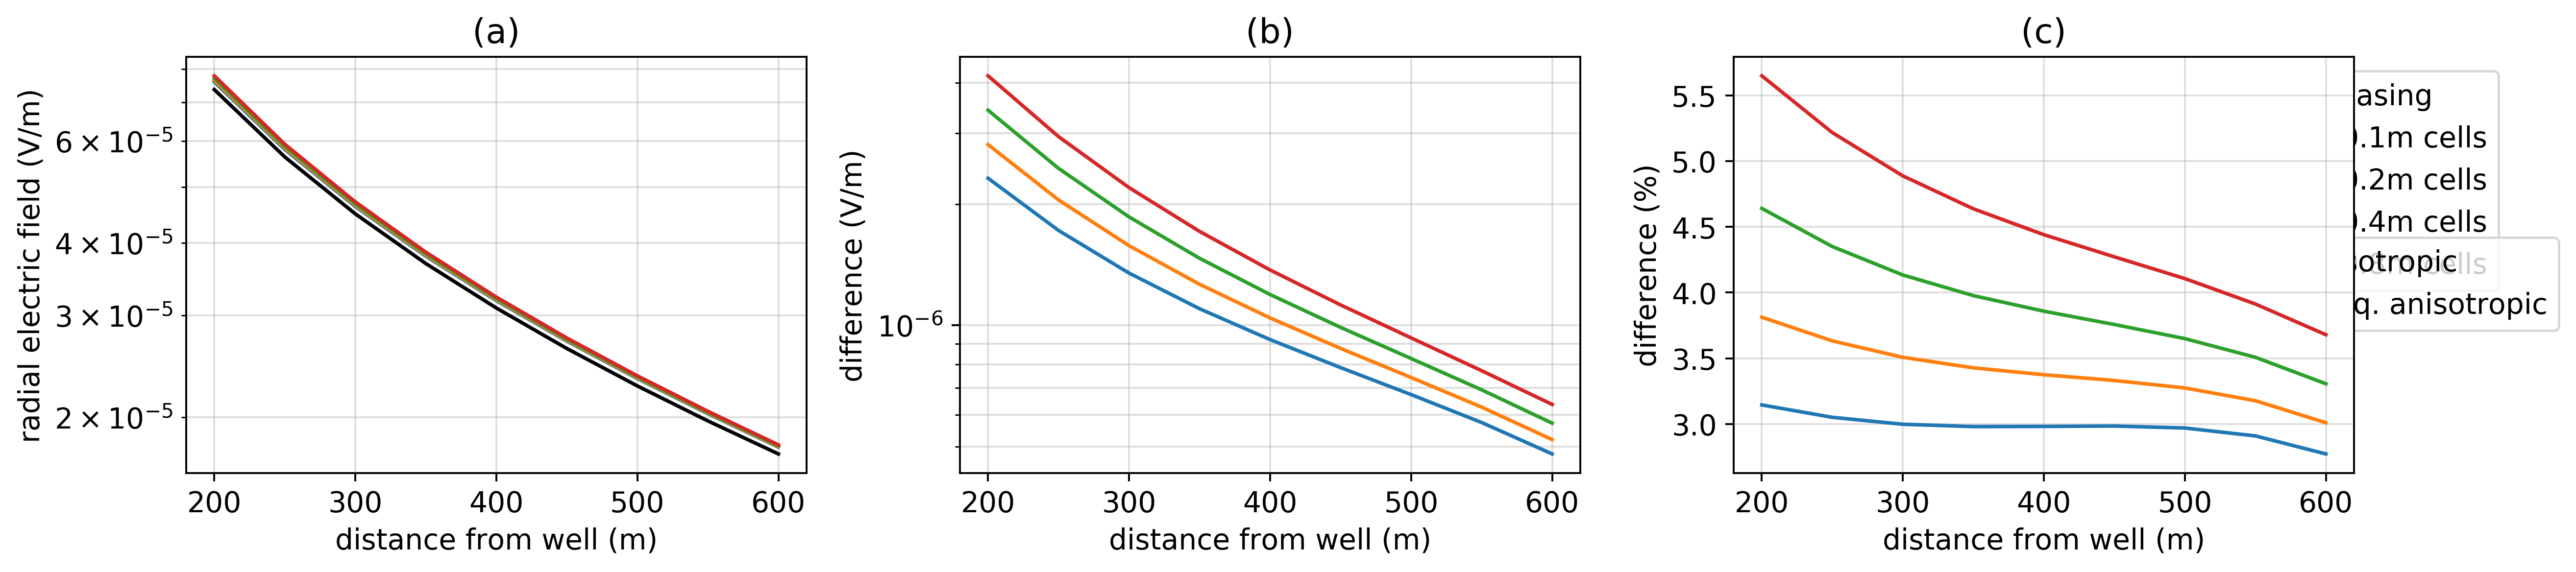

In [50]:
fig, ax  =  plt.subplots(1, 3, figsize=(14, 3.5), dpi=350)

rx_locs = discretize.utils.ndgrid(
    [ rx_y, np.r_[0.],      np.r_[-1.25]]
)

# key = "cartesian"
# f = fields_dict[key]
# src = survey.srcList[0]

# charges_casing = charges_casing*2. 

# casing
ax[0].semilogy(rx_y, np.absolute(e_cyl), label="casing", color="k")

for i, cs in enumerate(csx_cart):
    msh = cart_mesh_dict[cs]
    PFy = msh.getInterpolationMat(rx_locs, locType = "Fx")
    
    for key, ls in zip(["iso"], ['-', '--']):
        
        e_plt = discretize.utils.mkvc(PFy * (fields_dict_cart[cs][key][:, 'e']))
        label = "{}m cells".format(cs) if ls == "-" else None

        # cartesian
        ax[0].semilogy(rx_y, e_plt, label=label, color="C{}".format(i), ls=ls)
        ax[1].semilogy(rx_y, (e_plt - e_cyl), label=label, color="C{}".format(i), ls=ls)
        ax[2].plot(rx_y, (e_plt - e_cyl) / e_cyl * 100, label=label, color="C{}".format(i), ls=ls)


# [a.set_xlim([2., casing_l]) for a in ax.flatten()]
#     # [a.legend() for a in ax]
#     # [a.set_xlabel('depth / casing length') for a in ax]
[a.grid(which='both', alpha=0.4) for a in ax.flatten()]

ax[0].set_ylabel('radial electric field (V/m)')
ax[1].set_ylabel('difference (V/m)')
ax[2].set_ylabel('difference (%)')


for a in ax:
    a.set_xlabel("distance from well (m)")

ax[0].legend(bbox_to_anchor=[3.75, 1])
# ax[1, 0].set_ylim(0.2e-12*np.r_[-1, 1])
# ax[0, 1].set_ylim(1e-2*np.r_[-1, 1])
# ax[0, 2].set_ylim(np.r_[0, 5])

ax[1].legend(
    handles=[
        mlines.Line2D([], [], color='k', linestyle='-', label='isotropic'), 
        mlines.Line2D([], [], color='k', linestyle='--', label='eq. anisotropic')
    ], bbox_to_anchor=[2.6, 0.6]
)
# [a.ticklabel_format(scilimits=(0, 3)) for a in ax[1, :]]
# [a.update_ticks() for a in ax[1, :]]
[a.set_title("({})".format(ascii_lowercase[i])) for i, a in enumerate(ax.flatten())]

#     # ax[0].set_ylabel('downward-going current (A)')
#     # ax[1].set_ylabel('charge (C)')

#     # ax[1].set_ylim(8e-12*np.r_[0, 1])
#     # # [a.set_xlim([-mod.src_a[2]/mod.casing_l, 1.]) for a in ax]

# # ax[0].set_title('(a)')
# # ax[1].set_title('(b)')
# ax[0, 2].set_ylim([-45, 9])
# ax[1, 0].set_ylim(1e-12 * np.r_[-0.1, 1.2])
# ax[1, 1].set_ylim(1e-13 * np.r_[-0.3, 1])
# ax[1, 2].set_ylim(np.r_[-20, 20])
plt.tight_layout()

fig.savefig("approximating_wells_cartesian_efield", bbox_inches="tight", dpi=350)

In [51]:
# # plot e-field on surface

# epsilon = 1e-16

# def plot_ex_field(theta_ind=1, src_ind=0, xmin=10, xmax=500, zloc=0):
#     xlim = [xmin, xmax]
#     src_baseline = simDict['baseline'].survey.srcList[src_ind]

#     fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=400)
#     for i, key in enumerate(model_names):
#         f = fieldsDict[key]
#         src = simDict[key].survey.srcList[src_ind]
#         casingSim.view.plotLinesFx(
#             cylMeshGen.mesh, field=f[src,'e'],
#             pltType='semilogy', ax=ax[0],
#             theta_ind=theta_ind, xlim=xlim, 
#             color_ind=i, label=key, 
#             zloc=zloc
#         )

#         if key != 'baseline':
#             f = fieldsDict[key]
#             casingSim.view.plotLinesFx(
#                 cylMeshGen.mesh,
#                 field=100*(
#                     np.absolute(f[src,'e'] - fieldsDict['baseline'][src_baseline,'e'])/
#                     (np.absolute(fieldsDict['baseline'][src_baseline,'e']) + epsilon)
#                 ),
#                 pltType='plot', ax=ax[1],
#                 theta_ind=theta_ind, xlim=xlim, 
#                 color_ind=i, label=key, zloc=zloc
#             )
    
# #     print('src_a = {}'.format(src_a[src_ind, :]))
#     ax[0].legend()
#     ax[0].set_ylabel('Electric Field (V/m)') 
#     ax[0].set_title(src_names[src_ind])

#     ax[1].legend()
#     ax[1].set_ylabel('percent difference')
#     plt.tight_layout()
#     plt.show()


In [52]:
# ipywidgets.interact(
#     plot_ex_field,
#     theta_ind = ipywidgets.IntSlider(min=0, max=len(cylMeshGen.hy)-1, value=1),
#     src_ind = ipywidgets.IntSlider(min=0, max=src_a.shape[0]-1, value=0),
#     xmin = ipywidgets.FloatText(value=10), 
#     xmax = ipywidgets.FloatText(value=500),
#     zloc = ipywidgets.FloatText(value=0)
# )

## Plot the casing currents

In [53]:
# # plot currents in casing

# epsilon = 1e-16

# def plot_casing_currents(src_ind=0):
   
#     src_baseline = simDict['baseline'].survey.srcList[src_ind]

#     fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=400)
#     ax = discretize.utils.mkvc(ax)

#     baseline_src = simDict['baseline'].survey.srcList[src_ind]
#     currents_baseline = casingSim.physics.casing_currents(
#         fieldsDict['baseline'][baseline_src, 'j'], cylMeshGen.mesh, 
#         modelDict['baseline']
# #         modelDict['baseline'].casing_a, 
# #         0,
# #         modelDict['baseline'].casing_b, modelDict['baseline'].casing_z,
#     )
    
#     for i, key in enumerate(model_names):
#         f = fieldsDict[key]
#         src = simDict[key].survey.srcList[src_ind]
#         mod = modelDict[key]
        
#         currents = casingSim.physics.casing_currents(
#             f[src, 'j'], cylMeshGen.mesh, mod 
# #             mod.casing_a if key == 'baseline' else 0, 
# #             mod.casing_b, mod.casing_z,
#         )
        
#         ax[0].plot(currents["z"][0], -currents["z"][1], label=key, color="C{}".format(i))
# #         ax[2].plot(cylMeshGen.mesh.vectorCCz, ix, label=key, color="C{}".format(i))

#         if key != 'baseline':
        
#             ax[1].plot(
#                 currents["z"][0], 
#                 np.absolute(
#                     currents["z"][1]-currents_baseline["z"][1]
#                 )/(
#                     np.absolute(currents_baseline["z"][1])+epsilon
#                 )*100,
#                 label=key, color="C{}".format(i)
#             )
# #             ax[3].plot(
# #                 cylMeshGen.mesh.vectorCCz, 
# #                 np.absolute(ix-ix_baseline)/(np.absolute(ix_baseline)+epsilon),
# #                 label=key, color="C{}".format(i)
# #             )
            
    
#     [a.set_xlim([0., -casing_l]) for a in ax]
#     [a.legend() for a in ax]
#     [a.set_xlabel('depth (m)')]
# #     ax[0].set_ylabel('Electric Field (V/m)')    

# #     ax[1].legend()
# #     ax[1].set_ylabel('percent difference')

#     ax[0].set_ylabel('Downward-going Current (A)')
#     ax[1].set_ylabel('Percent difference from baseline')
    
#     ax[0].set_title(src_names[src_ind] + ' source \n\n Vertical Current in Casing')
#     ax[1].set_title('Difference from baseline (%)')
    
    
#     plt.tight_layout()
#     plt.show()

In [54]:
# ipywidgets.interact(
#     plot_casing_currents, 
#     src_ind = ipywidgets.IntSlider(min=0, max=src_a.shape[0]-1, value=0)
# )

In [55]:
# casingSim.physics.casing_currents?

In [56]:
# # plot currents in casing

# epsilon = 1e-16

# def plot_casing_currents_multisrc(model='baseline'):

#     fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=400)
#     ax = discretize.utils.mkvc(ax)

#     f = fieldsDict[model]
#     mod = modelDict[model]
        
#     for i, src in enumerate(simDict[model].survey.srcList):
        
#         currents = casingSim.physics.casing_currents(
#             f[src, 'j'], cylMeshGen.mesh, mod 
# #             mod.casing_b, mod.casing_z,
#         )
        
#         ax[0].plot(currents["z"][0], -currents["z"][1], label=src_names[i], color="C{}".format(i))
#         ax[1].plot(currents["z"][0], np.absolute(currents["z"][1]), label=src_names[i], color="C{}".format(i))
        
            
    
#     [a.set_xlim([0., -casing_l]) for a in ax]
#     [a.legend() for a in ax]
#     [a.set_xlabel('z (m)') for a in ax]

#     ax[0].set_ylabel('Downward-going Current (A)')
#     ax[1].set_ylabel('Vertical Current Amplitude (A)')
    
#     plt.tight_layout()
#     plt.show()

In [57]:
plot_casing_currents_multisrc()

NameError: name 'plot_casing_currents_multisrc' is not defined

In [ ]:
# def horizontal_current_flux(mesh, j, radius=1):
#     Fx_inds = np.absolute(mesh.gridFx[:,0] - radius) == np.min(np.absolute(mesh.vectorNx - radius))

#     jA = utils.sdiag(mesh.area) * j
#     jA_surface = jA[
#         np.hstack([Fx_inds, np.zeros(mesh.nFy, dtype=bool), np.zeros(mesh.nFz, dtype=bool)])
#     ].reshape(mesh.vnFx[1], mesh.vnFx[2], order='F')

#     ix = jA_surface.sum(0)
    
#     return ix

In [ ]:
# # plot currents in casing

# epsilon = 1e-16

# def plot_formation_currents(src_ind=0, radius=1, ymax=None):
   
#     src_baseline = simDict['baseline'].survey.srcList[src_ind]

#     fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=400)
#     ax = discretize.utils.mkvc(ax)

#     baseline_src = simDict['baseline'].survey.srcList[src_ind]
#     ix_baseline = horizontal_current_flux(
#         cylMeshGen.mesh, fieldsDict['baseline'][baseline_src, 'j'], radius
#     )
    
#     for i, key in enumerate(model_names):
#         f = fieldsDict[key]
#         src = simDict[key].survey.srcList[src_ind]
        
#         ix = horizontal_current_flux(
#             cylMeshGen.mesh, fieldsDict[key][src, 'j'], radius
#         )
        
#         ax[0].plot(cylMeshGen.mesh.vectorCCz, ix, label=key, color="C{}".format(i))

#         if key != 'baseline':
        
#             ax[1].plot(
#                 cylMeshGen.mesh.vectorCCz, 
#                 np.absolute(ix-ix_baseline)/(np.absolute(ix_baseline)+epsilon)*100,
#                 label=key, color="C{}".format(i)
#             )
    
#     [a.set_xlim([0., -1.25*casing_l]) for a in ax]
#     [a.legend() for a in ax]
#     [a.set_xlabel('z (m)') for a in ax]
    
#     if not ymax is not None or ymax !=0:
#         ylim = [0, ymax]
#         ax[0].set_ylim(ylim)

#     ax[0].set_ylabel('Horizontal currents (A)')
#     ax[1].set_ylabel('Percent difference from baseline')
    
#     ax[0].set_title(src_names[src_ind] + ' source \n\n Horizontal Current in Formation, r={}'.format(radius))
#     ax[1].set_title('Difference from baseline (%)')
    
    
#     plt.tight_layout()
#     plt.show()

In [ ]:
# ipywidgets.interact(
#     plot_formation_currents,
#     src_ind=ipywidgets.IntSlider(min=0, max=len(src_names)-1, value=0), 
#     radius=ipywidgets.FloatText(value=10),
#     ymax=ipywidgets.FloatText(value=0)
# )

In [ ]:
# # plot currents in casing

# epsilon = 1e-16

# def plot_formation_currents_multisrc(radius=100, model='baseline'):
   
#     fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=400)
#     ax = discretize.utils.mkvc(ax)
    
#     f = fieldsDict[model]
    
#     for i, src in enumerate(simDict[model].survey.srcList):
        
#         ix = horizontal_current_flux(
#             cylMeshGen.mesh, fieldsDict[model][src, 'j'], radius
#         )
        
#         ax[0].plot(cylMeshGen.mesh.vectorCCz, ix, label=src_names[i], color="C{}".format(i))
#         ax[1].semilogy(cylMeshGen.mesh.vectorCCz, np.abs(ix), label=src_names[i], color="C{}".format(i))
    
#     [a.set_xlim([0., -1.25*casing_l]) for a in ax]
#     [a.legend() for a in ax]
#     [a.set_xlabel('z (m)') for a in ax]

#     [a.set_ylabel('Horizontal currents (A)') for a in ax]
    
#     ax[0].set_title('Horizontal Current in Formation, r={}'.format(radius))
# #     ax[1].set_title('')
    
#     ax[1].set_ylim([1e-4, 2e-1])
#     plt.tight_layout()
#     plt.show()
    
#     return ax

In [ ]:
# plot_formation_currents_multisrc()

## Charges

How do the charges change with different casing models?

In [ ]:
# # Plot the charges
# mesh2D = cylMeshGen.create_2D_mesh().mesh

# def plotScalar(
#     theta_ind=0, src_ind=0, clim_max=None, clim_min=None, 
#     max_depth=1.1*model.casing_l, 
#     max_r=0.1, top=10., view='charge', model='all'
# ):
    
#     model_names = model_names if model == 'all' else [model]
    
#     fig, ax = plt.subplots(1, len(model_names), figsize=(len(model_names)*5, 6))
    
#     assert view.lower() in ['charge', 'phi', 'j']

#     xlim = max_r*np.r_[0, 1]  # x-limits in meters
#     zlim = np.r_[-max_depth, top]  # z-limits in meters. (z-positive up)
    
#     clim = None
#     plotopts = {
#         'theta_ind': theta_ind,
#     }
#     if not clim_max is not None or clim_max != 0.:
#         clim = clim_max * np.r_[-1, 1]
#         plotopts['clim'] = clim

#         if clim_min is not None or clim_min != 0.:
#             plotopts['clim'][0] = clim_min
            
#     if len(model_names) == 1:
#         ax = [ax] 
        
#     for a, title in zip(ax, model_names):
#         pp = physpropsDict[title]
#         src = simDict[title].survey.srcList[src_ind]
#         plotme = simDict[title].fields()[src, view]
        
#         if view in ['charge', 'phi']:
#             _, cb = pp.plot_prop(
#                 plotme,
#                 ax=a,
#                 pcolorOpts = {'cmap': 'bwr' if view == 'charge' else 'viridis'},
#                 **plotopts
#             )
#         elif view == 'j':
#             jplt = casingSim.face3DthetaSlice(
#                 cylMeshGen.mesh, plotme, theta_ind=theta_ind
#             )
            
#             _, cb = casingSim.plotFace2D(
#                 mesh2D,
#                 jplt, real_or_imag='real', ax=a, range_x=xlim,
#                 range_y=zlim, sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.],
#                 logScale=True, clim=clim
#             )
#         a.set_title('{} source \n {} model \n\n $\sigma$ = {:1.2e}S/m, \ntheta = {:1.1f} degrees'.format(
#             src_names[src_ind], title, pp.modelParameters.sigma_casing, cylMeshGen.mesh.vectorCCy[theta_ind]*180/np.pi
#         ), fontsize=13)
#     #     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
#         a.set_xlim(xlim)
#         a.set_ylim(zlim)
# #         cb.set_label(view)
        
#         # plot outline of casing
#         m = modelDict[title]
#         a.plot(
#             np.r_[m.casing_a, m.casing_a, m.casing_b, m.casing_b, m.casing_a],
#             np.r_[m.casing_z[1], m.casing_z[0], m.casing_z[0], m.casing_z[1], m.casing_z[1]],
#             'k', 
#             lw = 0.5
#         )
#     plt.tight_layout()
#     plt.show()

### Widget for viewing charges

There are 3 panels, the true (left), if we were to replace the well with solid steel (center) and if we choose sigma to preserve the integrated conductance (right). For reference, I have plotted the true casing cross section.

The widgets available to you are
- **theta_ind**: [0, ntheta slices] Which azimuth should we slice through
- **clim_max**: max value on the colorbar so you can saturate it
- **max_depth**: max z-limit for the plot
- **top**: top of the plot (z)

observations:
- (sanity checks): in all charges at interface between casing and formation. All positive charges (positive electrode connected to casing
- charge distribution more uniform along length of casing for solid steel (also makes sense: better conductor)

In [ ]:
# # fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi=350)

# ipywidgets.interact(
#     plotScalar,
#     theta_ind = ipywidgets.IntSlider(min=0, max=len(cylMeshGen.hy)-1, value=1),
#     src_ind = ipywidgets.IntSlider(min=0, max=src_a.shape[0]-1, value=0),
#     clim_max = ipywidgets.FloatText(value=0),
#     clim_min = ipywidgets.FloatText(value=0),
#     max_depth = ipywidgets.FloatText(value=np.ceil(1.25*model.casing_l)), 
#     max_r = ipywidgets.FloatText(value=0.1),
#     top = ipywidgets.FloatText(value=10),
#     view = ipywidgets.ToggleButtons(
#         options=['charge', 'phi', 'j'], value='charge'
#     ),
#     model = ipywidgets.ToggleButtons(
#         options=['baseline', 'solid', 'sigma_A', 'all'], value='baseline'
#     )
# )   

In [ ]:
# # Plot the models

# def plotScalarDifference(
#     clim_max=None, theta_ind=0, src_ind=0, max_depth=1.1*model.casing_l, max_r=0.1, top=10.,  view='charge', 
# ):
#     assert view in ['charge', 'phi']
        
#     fig, ax = plt.subplots(1, len(model_names)-1, figsize=(5*(len(model_names)-1), 5))
    
#     xlim = max_r*np.r_[0, 1]  # x-limits in meters
#     zlim = np.r_[-max_depth, top]  # z-limits in meters. (z-positive up)
    
#     src_baseline = simDict['baseline'].survey.srcList[src_ind]
    
#     for a, title in zip(ax, ['solid', 'sigma_A']):
#         pp = physpropsDict[title]
#         src = simDict[title].survey.srcList[src_ind]
#         plotme = simDict[title].fields()[src, view] - simDict['baseline'].fields()[src_baseline, view]
        
#         if clim_max is None or clim_max == 0.:
#             clim = np.absolute(plotme).max() * np.r_[-1., 1.]
#         else: 
#             clim = clim_max * np.r_[-1, 1]
        
#         _, cb = pp.plot_prop(
#             plotme,
#             ax=a,
#             pcolorOpts={
#                 'cmap': 'bwr' if view == 'charge' else 'viridis',
#             },
#             clim=clim,
#             theta_ind=theta_ind
#         )
#         a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m\ntheta = {:1.2f} degree'.format(
#             title, pp.modelParameters.sigma_casing, cylMeshGen.mesh.vectorCCy[theta_ind]*180/np.pi
#         ), fontsize=13)
#     #     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
#         a.set_xlim(xlim)
#         a.set_ylim(zlim)
#         cb.set_label('secondary ' + view)
        
#         # plot outline of casing
#         m = modelDict[title]
#         a.plot(
#             np.r_[m.casing_a, m.casing_a, m.casing_b, m.casing_b, m.casing_a],
#             np.r_[m.casing_z[1], m.casing_z[0], m.casing_z[0], m.casing_z[1], m.casing_z[1]],
#             'k' if view == 'charge' else 'w', 
#             lw = 0.5
#         )
    
#     plt.tight_layout()
#     plt.show()

### Plot the difference in charge distributions (approximation - true) 

observations: 
- first: colorbar scales are different between the two! 
- solid steel: more negative at top, positive at bottom (consistent with more uniform charge distribution) 

In [ ]:
# ipywidgets.interact(
#     plotScalarDifference,
#     theta_ind = ipywidgets.IntSlider(min=0, max=len(cylMeshGen.hy)-1, value=1),
#     src_ind = ipywidgets.IntSlider(min=0, max=src_a.shape[0]-1, value=0),
#     clim_max = ipywidgets.FloatText(value=0), 
#     max_depth = ipywidgets.FloatText(value=1.25*model.casing_l), 
#     max_r = ipywidgets.FloatText(value=0.1),
#     top = ipywidgets.FloatText(value=10),
#     view = ipywidgets.ToggleButtons(options=['charge', 'phi'], value='charge'), 
# )

### Total charge on the casing

- integrate the charge on the casing. 

In [ ]:
# for src_ind in range(src_a.shape[0]):
#     print('\n----- src {} ------'.format(src_a[src_ind,[0,2]]))
#     casing_charge = {}
#     for title in model_names:
#         casing_charge[title] = (
#             utils.mkvc(simDict[title].fields()[simDict[title].survey.srcList[src_ind], 'charge'])
#         )[modelDict[title].ind_casing(cylMeshGen.mesh)].sum()
#         print('{:8s}: {:1.3e}'.format(title, casing_charge[title]))

In [ ]:
# print(np.finfo(float).eps)